In [26]:
from dotenv import load_dotenv
from pathlib import Path
import os
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, BaseMessage
from langchain_tavily import TavilySearch 
from IPython.display import Image, display
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from typing import Literal, List
from typing_extensions import TypedDict
import random



from langgraph.graph import START, StateGraph, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode



gpt4o_chat = ChatOpenAI(model="gpt-4o", temperature=0)
gpt35_chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
gpt52_chat = ChatOpenAI(model="gpt-5.2", temperature=0)


# Path to the .env file in the parent folder
env_path = Path("..") / ".env"
load_dotenv(dotenv_path=env_path)


True

In [24]:
import os
from dotenv import load_dotenv

# Clear existing environment variables
for key in ['LANGSMITH_TRACING', 'LANGSMITH_ENDPOINT', 'LANGSMITH_API_KEY', 'LANGSMITH_PROJECT']:
    os.environ.pop(key, None)

# Reload the .env file
load_dotenv(override=True)  # override=True is key!

# Verify the new values

print("Endpoint:", os.getenv("LANGSMITH_ENDPOINT"))
print("Project:", os.getenv("LANGSMITH_PROJECT"))

Endpoint: https://api.smith.langchain.com
Project: bea


In [4]:
from langchain_core.messages import HumanMessage

# Create a message
msg = HumanMessage(content="Hello world", name="Lance")

# Message list
messages = [msg]

# Invoke the model with a list of messages 
gpt52_chat.invoke(messages)

AIMessage(content='Hello world, Lance.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 10, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5.2-2025-12-11', 'system_fingerprint': None, 'id': 'chatcmpl-D6uwxK4iNx0a7KtYEAkemqpHrZzIg', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c3c7b-8782-7da1-81b6-ae9d016b0948-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 10, 'output_tokens': 8, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:


tavily_search = TavilySearch(max_results=3)

data = tavily_search.invoke({"query": "What is LangGraph?"})
search_docs = data.get("results", data)
print(search_docs)

[{'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/', 'title': 'What is LangGraph?', 'content': 'LangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows.', 'score': 0.9486564, 'raw_content': None}, {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial', 'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?', 'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what 

In [6]:

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def multiply(a: int, b: int) -> int:
    """Multiplies a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

def web_search(query: str) -> str:
    """
    Search the web for a query using Tavily and return a text summary.

    Args:
        query: The search query string.

    Returns:
        A string containing the concatenated search results.
    """
    data = tavily_search.invoke({"query": query})
    search_docs = data.get("results", data)

    texts = []
    for doc in search_docs:
        if isinstance(doc, dict):
            # If 'text' key exists, use it, else stringify the dict
            texts.append(doc.get('text') or str(doc))
        else:
            texts.append(str(doc))

    return "\n".join(texts)


tools = [add, multiply, divide, web_search]

In [7]:
# Define LLM with bound tools
llm = ChatOpenAI(model="gpt-5.2", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="You are a helpful assistant. Use the tools at your disposal to answer the user's question. If you use a tool, respond with the tool call and its arguments in the following format: TOOL_NAME(arg1=value1, arg2=value2). Only use the tools when necessary.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}



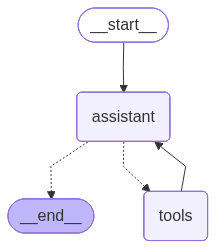

In [8]:


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [9]:
messages = [HumanMessage(content="Add 3 and 14.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_gQ2Kl9lAgvdodlIyuHnsBHRz)
 Call ID: call_gQ2Kl9lAgvdodlIyuHnsBHRz
  Args:
    a: 3
    b: 14
================================= Tool Message =================================
Name: add

17
================================== Ai Message ==================================

17


In [10]:
messages = [HumanMessage(content="What happened today in Oslo?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What happened today in Oslo?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_4AGyYIj6YjPT0ibfLM3FnSfy)
 Call ID: call_4AGyYIj6YjPT0ibfLM3FnSfy
  Args:
    query: What happened today in Oslo? news today Oslo
================================= Tool Message =================================
Name: web_search

{'url': 'https://www.the-independent.com/topic/oslo', 'title': 'Oslo - latest news, breaking stories and comment - The Independent', 'content': 'News · Police arrest man after gun fired in Oslo shopping centre · Sweden Nobels. News · Nobel laureates arrive for a week of events and awards in Stockholm and', 'score': 0.6651719, 'raw_content': None}
{'url': 'https://ground.news/interest/oslo-norway_10140a', 'title': 'Oslo Breaking News Headlines Today - Ground News', 'content': "Norwegian crown princess issues apology to those 'disappointed' by 

In [11]:
messages = [HumanMessage(content="What happened today in Oslo - news on vg, provide date and time?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What happened today in Oslo - news on vg, provide date and time?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_wnT81FFKNSFuVntEnSD8b3Y7)
 Call ID: call_wnT81FFKNSFuVntEnSD8b3Y7
  Args:
    query: site:vg.no Oslo i dag tidspunkt
================================= Tool Message =================================
Name: web_search

{'url': 'https://www.vg.no/nyheter/i/158vbQ/reagerer-kraftig-etter-terrorrapport-i-dag-er-jeg-sint', 'title': 'Reagerer kraftig etter terrorrapport: – I dag er jeg sint', 'content': 'De reagerer kraftig på avsløringene som har kommet frem om barskytingen i Oslo i dag. – I dag er jeg sint, i dag har jeg endelig fått vite', 'score': 0.99863297, 'raw_content': None}
{'url': 'https://www.vg.no/nyheter/i/bmrVlB/bystyret-i-oslo-har-vedtatt-at-utesteder-i-sentrum-faar-skjenke-alkohol-fra-klokken-08-00-paa-17-mai-og-andre-roede

In [12]:
messages = [HumanMessage(content="What day and time is now in Norway?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What day and time is now in Norway?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_fiJIWuO9WFQjCn2HybIjhl21)
 Call ID: call_fiJIWuO9WFQjCn2HybIjhl21
  Args:
    query: current local time in Norway now
================================= Tool Message =================================
Name: web_search

{'url': 'https://www.thetimenow.com/norway', 'title': 'Current Local Time in Norway - The Time Now', 'content': 'Current local time and weather in Norway. 12 hour 24 hour. 5:26:29 PM. UTC/GMT +1 hour. 07. Saturday. Feb 2026. Compare Time Difference Between 2 Cities.', 'score': 0.99998784, 'raw_content': None}
{'url': 'https://www.worldtimeserver.com/current_time_in_NO.aspx', 'title': 'Current local time in Norway', 'content': 'World Time Database. Current Time in Norway. What Time Is It In Norway?Local Time. 6:35:30 AM. Sunday, February 8, 2026. C

In [13]:
messages = [HumanMessage(content="What is bitcoin price at the moment?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is bitcoin price at the moment?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_Gt7cQh9kUD6v2AENqLuXDRcy)
 Call ID: call_Gt7cQh9kUD6v2AENqLuXDRcy
  Args:
    query: current bitcoin price USD right now
================================= Tool Message =================================
Name: web_search

{'url': 'https://www.binance.com/en/price/bitcoin', 'title': 'Bitcoin Price Today | BTC to USD Live Price, Market Cap & Chart', 'content': 'The live price of Bitcoin is $70,517.29 per (BTC / USD) with a current market cap of $1,409.36B USD. 24-hour trading volume is $49.29B USD.', 'score': 0.9986541, 'raw_content': None}
{'url': 'https://coinmarketcap.com/currencies/bitcoin/', 'title': 'Bitcoin price today, BTC to USD live price, marketcap and chart', 'content': 'The live Bitcoin price today is $69753.12 USD with a 24-hour trading volume of $4

In [14]:
messages = [HumanMessage(content="Add 5 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 5 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_EijN5sKbqh3cJBHAPqfcCEtt)
 Call ID: call_EijN5sKbqh3cJBHAPqfcCEtt
  Args:
    a: 5
    b: 4
================================= Tool Message =================================
Name: add

9
================================== Ai Message ==================================

9


In [15]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

What number (or result) should I multiply by 2? Please paste it or remind me what “that” refers to.


In [16]:

memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [17]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_l68VB2kok4AH9aAI8SKiiCKt)
 Call ID: call_l68VB2kok4AH9aAI8SKiiCKt
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

7


In [18]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_l68VB2kok4AH9aAI8SKiiCKt)
 Call ID: call_l68VB2kok4AH9aAI8SKiiCKt
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

7
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_w9gTz34rxhJBAL0dBz0rYWaU)
 Call ID: call_w9gTz34rxhJBAL0dBz0rYWaU
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

14


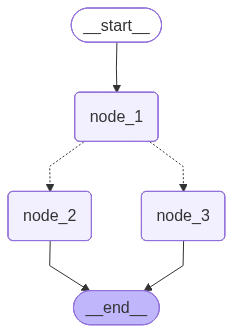

In [19]:


# State
class State(TypedDict):
    graph_state: str

# Conditional edge
def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

# Nodes
def node_1(state):
    print("---Node 1---")
    return {"graph_state":state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state":state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state":state['graph_state'] +" sad!"}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile graph
graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:
result = graph.invoke(
    {"graph_state": "Today"}
)

print("\nFinal result:", result)


---Node 1---
---Node 3---

Final result: {'graph_state': 'Today I am sad!'}


In [21]:
llm = ChatOpenAI(model="gpt-5.2", temperature=0)

def decide_mood(state) -> Literal["node_2", "node_3"]:
    user_input = state["graph_state"]

    prompt = f"""
    A user wrote the following text:

    "{user_input}"

    1. Identify three things that are on the user's mind.
    2. Decide if their overall mood is POSITIVE or NEGATIVE.

    Respond with ONLY one word:
    POSITIVE or NEGATIVE
    """

    response = llm.invoke([HumanMessage(content=prompt)])
    decision = response.content.strip().upper()

    if decision == "POSITIVE":
        return "node_2"

    return "node_3"


In [22]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state["graph_state"] + " | I am feeling"}

def node_2(state):
    print("---Node 2 (Positive)---")
    return {"graph_state": state["graph_state"] + " optimistic and motivated."}

def node_3(state):
    print("---Node 3 (Negative)---")
    return {"graph_state"---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[3], line 3
      1 from langgraph.graph import StateGraph, START, END
----> 3 builder = StateGraph(State)
      5 builder.add_node("ask_user", ask_user)
      6 builder.add_node("node_2", node_2)

NameError: name 'State' is not defined: state["graph_state"] + " overwhelmed and stressed."}


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2180066555.py, line 11)

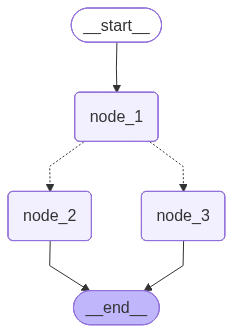

In [ ]:
builder = StateGraph(State)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
result = graph.invoke({
    "graph_state": "I’m thinking about sun mermaids and unicorns."
})

print("\nFinal result:")
print(result)


---Node 1---
---Node 2 (Positive)---

Final result:
{'graph_state': 'I’m thinking about sun mermaids and unicorns. | I am feeling optimistic and motivated.'}


In [ ]:

class State(TypedDict):
    messages: List[BaseMessage]


def ask_user(state):
    question = (
        "Before we continue, tell me three things that are on your mind right now."
    )

    print("🤖:", question)

    user_reply = input("🧑: ")

    return {
        "messages": state["messages"] + [
            AIMessage(content=question),
            HumanMessage(content=user_reply),
        ]
    }

def decide_mood(state) -> Literal["node_2", "node_3"]:
    last_user_message = state["messages"][-1].content

    prompt = f"""
    The user said:

    "{last_user_message}"

    1. Identify three things the user is thinking about.
    2. Decide if their overall mood is POSITIVE or NEGATIVE.

    Respond with ONLY:
    POSITIVE or NEGATIVE
    """

    result = llm.invoke([HumanMessage(content=prompt)])
    decision = result.content.strip().upper()

    if decision == "POSITIVE":
        return "node_2"
    return "node_3"

def node_2(state):
    msg = "It sounds like you're feeling positive and motivated 🙂"
    print("🤖:", msg)

    return {
        "messages": state["messages"] + [AIMessage(content=msg)]
    }

def node_3(state):
    msg = "It sounds like you have a lot on your mind — that can feel heavy 💛"
    print("🤖:", msg)

    return {
        "messages": state["messages"] + [AIMessage(content=msg)]
    }


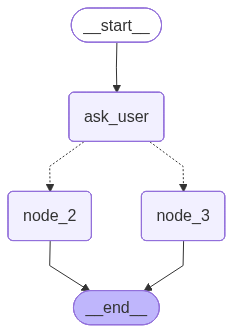

In [ ]:
llm = ChatOpenAI(model="gpt-5.2", temperature=0)

builder = StateGraph(State)

builder.add_node("ask_user", ask_user)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "ask_user")
builder.add_conditional_edges("ask_user", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph1 = builder.compile()
display(Image(graph1.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
graph1.invoke({
    "messages": []
})


🤖: Before we continue, tell me three things that are on your mind right now.
🤖: It sounds like you have a lot on your mind — that can feel heavy 💛


{'messages': [AIMessage(content='Before we continue, tell me three things that are on your mind right now.', additional_kwargs={}, response_metadata={}, tool_calls=[], invalid_tool_calls=[]),
  HumanMessage(content='heavy rain and greedy blood', additional_kwargs={}, response_metadata={}),
  AIMessage(content='It sounds like you have a lot on your mind — that can feel heavy 💛', additional_kwargs={}, response_metadata={}, tool_calls=[], invalid_tool_calls=[])]}

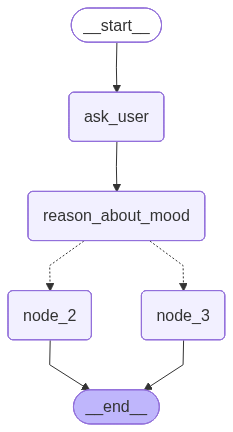

In [ ]:
llm = ChatOpenAI(model="gpt-5.2", temperature=0)# Define State
class State(TypedDict):
    messages: List[BaseMessage]

# -----------------------------
# Nodes
# -----------------------------
def ask_user(state: State) -> State:
    question = "Before we continue, tell me three things that are on your mind right now."
    print("🤖:", question)
    user_reply = input("🧑: ")
    return {
        "messages": state["messages"] + [
            AIMessage(content=question),
            HumanMessage(content=user_reply)
        ]
    }

def reason_about_mood(state: State) -> State:
    """
    This node only processes LLM reasoning and adds a 'mood' key to state.
    """
    last_user_message = state["messages"][-1].content
    prompt = f"""
    The user said:

    "{last_user_message}"

    1. Identify three things the user is thinking about.
    2. Decide if their overall mood is POSITIVE or NEGATIVE.

    Respond with ONLY: POSITIVE or NEGATIVE
    """
    llm = ChatOpenAI(model="gpt-5.2", temperature=0)
    result = llm.invoke([HumanMessage(content=prompt)])
    state["mood"] = result.content.strip().upper()
    return state

def node_2(state: State) -> State:
    msg = "It sounds like you're feeling positive and motivated 🙂"
    print("🤖:", msg)
    return {"messages": state["messages"] + [AIMessage(content=msg)]}

def node_3(state: State) -> State:
    msg = "It sounds like you have a lot on your mind — that can feel heavy 💛"
    print("🤖:", msg)
    return {"messages": state["messages"] + [AIMessage(content=msg)]}

# -----------------------------
# Conditional edge function
# -----------------------------
def decide_mood(state: State) -> Literal["node_2", "node_3"]:
    return "node_2" if state.get("mood") == "POSITIVE" else "node_3"

# -----------------------------
# Build Graph
# -----------------------------
builder = StateGraph(State)

builder.add_node("ask_user", ask_user)
builder.add_node("reason_about_mood", reason_about_mood)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Edges
builder.add_edge(START, "ask_user")
builder.add_edge("ask_user", "reason_about_mood")
builder.add_conditional_edges("reason_about_mood", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile and display
graph2 = builder.compile()
display(Image(graph2.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Run graph
result = graph2.invoke({"messages": []})
print("\nFinal result:", result)


🤖: Before we continue, tell me three things that are on your mind right now.
🤖: It sounds like you have a lot on your mind — that can feel heavy 💛

Final result: {'messages': [AIMessage(content='Before we continue, tell me three things that are on your mind right now.', additional_kwargs={}, response_metadata={}, tool_calls=[], invalid_tool_calls=[]), HumanMessage(content='holidays hot cold champagne ', additional_kwargs={}, response_metadata={}), AIMessage(content='It sounds like you have a lot on your mind — that can feel heavy 💛', additional_kwargs={}, response_metadata={}, tool_calls=[], invalid_tool_calls=[])]}


In [27]:
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [29]:
result = llm.invoke(messages)
type(result)
result

AIMessage(content='In the US, the most consistently good place to see orcas (killer whales) is the **Salish Sea / Puget Sound region**—especially around the **San Juan Islands in Washington** (Friday Harbor, Lime Kiln Point on San Juan Island, and nearby waters).\n\nOther top US options, depending on what kind of experience you want:\n\n- **Monterey Bay, California**: excellent for offshore whale-watching; orcas are seen, especially when following prey (often seasonal and less predictable than Washington).\n- **Southeast Alaska (Inside Passage: Juneau, Sitka, Ketchikan)**: very strong chances in summer, with beautiful scenery and frequent marine wildlife.\n\nIf you tell me **what month you’re going**, whether you prefer **shore-based viewing vs a boat tour**, and your **budget**, I can narrow it to the best specific spot and timing.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 184, 'prompt_tokens': 70, 'total_tokens': 254, 'completion_t

In [30]:
result.response_metadata

{'token_usage': {'completion_tokens': 184,
  'prompt_tokens': 70,
  'total_tokens': 254,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_provider': 'openai',
 'model_name': 'gpt-5.2-2025-12-11',
 'system_fingerprint': None,
 'id': 'chatcmpl-D6zTz7MeeQSiVHaIKtCELZDOPojPb',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}